# Capstone Project - Battle Of Neighborhoods

## Toronto Indian Restaurants 
### - Hari Srinivasan

## Introduction

Toronto is the provincial capital of Ontario and is considered the commercial capital of Canada.Toronto is an international centre of business, finance, arts, and culture, and is recognized as one of the most multicultural and cosmopolitan cities in the world.The diverse population of Toronto reflects its current and historical role as an important destination for immigrants to Canada. More than 50 percent of residents belong to a visible minority population group and over 200 distinct ethnic origins are represented among its inhabitants. (_source:Wikipedia_)

The cuisine of Toronto reflects Toronto's size and multicultural diversity. Numerous other world cuisines are available throughout the city, including Portuguese, Hungarian, Japanese, and Caribbean. In addition to ethnic cuisines, Toronto is also home to many fine dining establishments and chain restaurants ranging from fast food to casual or upscale dining. (_source:Wikipedia_)

As a part of this project, we will explore the neighborhoods of Toronto, we will research and visualize the areas that has great Indian restaurants.

## Background and Description of the Problem

For somebody trying to immigrate to Canada from India, there are multiple things to consider before the migration. The first thing that would make somebody homesick is the food in the area. This is true for many Indians trying to immigrate to a different country. Toronto is a home to multi-cultural cuisines and has many Indian restaurants. The challenge is to identify the best among those restaurants and the areas where they are concentrated.

This is one of the problems, we will try to address in this project.

Other questions that can be asked from the Analysis-
- Which is the best place to stay if I prefer Indian Cuisine?
- What is the best location in Toronto for Indian Cuisine? 
- Which areas lack Indian Restaurants and have potential for a new Indian Restaurant? 

## Data

### Data
For this project we need the following data :
* Toronto data that contains list Boroughs, Neighborhoods, Postal Code including Latitude and Longitude
    * Data source : 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
    * Description :  Contains data for Toronto with Postal code, Borough and Neighborhood details. We will add more data as needed to explore the Boroughs of Toronto.
* Indian restaurants in each neighborhood of Toronto. 
    * Data source : Fousquare API 
    * Description : We can use this api to get all the venues along with a list of Indian restaurants with ratings in each neighborhood. 

## Methodology

* Use the __wikipedia__ data combined with __Foursquare__ to get Borough and Neighborhood with the most number of Indian restaurants. 
* Identify the top restaurant for an area based on the results from 1 using 'ratings', 'likes' and 'tips'.
* Utilize _Bar chart_ visualization to get insights into Indian restaurant details.
* Summarize the results and draw conclusion


#### Steps

1. Import necessary libraries for data and feature engineering
2. Collect the Toronto data from https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M
3. Utilize Foursquare API to get the venue details and Indian restaurants 
4. Get ratings and tips for the restaurants from Foursquare API
5. Results, Conclusion and Discussion
*** Visualize data as needed for analysis

__1. Import necessary libraries__

In [1]:
import pandas as pd
import numpy as np
!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
#import geocoder
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import requests
import urllib.request
import time
from bs4 import BeautifulSoup

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 
import folium # map rendering library

from sklearn import preprocessing
%matplotlib inline

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.6.16          |           py36_1         149 KB  conda-forge
    geographiclib-1.49         |             py_0          32 KB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    ca-certificates-2019.6.16  |       hecc5488_0         145 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.49-py_0         conda-forge
    geopy:           1.20.0-py_0       conda-forge

The following packages will be UPDATED:

    ca-

__2. Collect Toronto Data__

In [2]:
wiki_can='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
resp = requests.get(wiki_can).text
soup = BeautifulSoup(resp, 'xml')#Beautiful Soup to Parse the url page
table=soup.find('table')
column_names=['Postalcode','Borough','Neighbourhood']
df = pd.DataFrame(columns=column_names)
# extracting information from the table
for tr_cell in table.find_all('tr'):
    row_data=[]
    for td_cell in tr_cell.find_all('td'):
        row_data.append(td_cell.text.strip())
    if len(row_data)==3:
        df.loc[len(df)] = row_data
# remove rows where Borough is 'Not assigned'
df=df[df['Borough']!='Not assigned']
# assign Neighbourhood=Borough where Neighbourhood is 'Not assigned'
df[df['Neighbourhood']=='Not assigned']=df['Borough']
df.head()

,Postalcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights


In [3]:
# group multiple Neighbourhood under one Postcode
temp_df=df.groupby('Postalcode')['Neighbourhood'].apply(lambda x: "%s" % ', '.join(x))
temp_df=temp_df.reset_index(drop=False)
temp_df.rename(columns={'Neighbourhood':'Neighbourhood_joined'},inplace=True)

# join the newly constructed joined data frame
df_merge = pd.merge(df, temp_df, on='Postalcode')

# drop the Neighbourhood column
df_merge.drop(['Neighbourhood'],axis=1,inplace=True)

# drop duplicates from the data frame
df_merge.drop_duplicates(inplace=True)

# rename Neighbourhood_joined back to Neighbourhood
df_merge.rename(columns={'Neighbourhood_joined':'Neighborhood'},inplace=True)

toronto_data=df_merge

toronto_data.head()

,Postalcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Harbourfront, Regent Park"
4,M6A,North York,"Lawrence Heights, Lawrence Manor"
6,Queen's Park,Queen's Park,Queen's Park


In [4]:
# As the Geocoder import has issues, we will use the csv provided by Coursera as an alternative
toronto_geo_df=pd.read_csv('http://cocl.us/Geospatial_data')
toronto_geo_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [5]:
toronto_geo_df.rename(columns={'Postal Code':'Postalcode'},inplace=True)
toronto_geo_merged = pd.merge(toronto_geo_df, df_merge, on='Postalcode')
toronto_geo_merged.head()

toronto_data=toronto_geo_merged[['Borough','Neighborhood','Latitude','Longitude']]
toronto_data.tail()

,Borough,Neighborhood,Latitude,Longitude
97,York,Weston,43.706876,-79.518188
98,Etobicoke,Westmount,43.696319,-79.532242
99,Etobicoke,"Kingsview Village, Martin Grove Gardens, Richv...",43.688905,-79.554724
100,Etobicoke,"Albion Gardens, Beaumond Heights, Humbergate, ...",43.739416,-79.588437
101,Etobicoke,Northwest,43.706748,-79.594054


__3. Connect to get Foursquare Location Data for Toronto__

In [6]:
CLIENT_ID = 'FGZH3PW500W4UBWXAFOTK21RT14QXK4CVYPH35ZVW5VYKVQV' # your Foursquare ID
CLIENT_SECRET = 'D5RWKFN35D30LIOU2VFVYJV20QMYW4XMXIZ2V21R5G0MDUYA' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [7]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'FGZH3PW500W4UBWXAFOTK21RT14QXK4CVYPH35ZVW5VYKVQV' # your Foursquare ID
    CLIENT_SECRET = 'D5RWKFN35D30LIOU2VFVYJV20QMYW4XMXIZ2V21R5G0MDUYA' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [8]:
# Check for a sample venue and categories -- Etobicoke	Albion Gardens, Beaumond Heights, Humbergate
get_venues(43.739416,-79.588437)

,ID,Name,Category
0,4b04a05bf964a520c45522e3,Sheriff's No Frills,Grocery Store
1,4be58dc4cf200f479154133c,Shoppers Drug Mart,Pharmacy
2,4c633939e1621b8d48842553,Subway,Sandwich Place
3,4ca8d10976d3a093d6c2196b,Bestco Food Mart,Grocery Store
4,4be70e26cf200f47e334153c,Popeyes Louisiana Kitchen,Fried Chicken Joint
5,4cd4738cdfb4a1cd4337535c,The Beer Store,Beer Store
6,4d8ba6910c4e41bdaaf7667f,Pizza Pizza,Pizza Place
7,4f60c4b6e4b0f4b0a38cd727,Pizza Hut,Pizza Place
8,5112b872e4b0c0a78d7bcd27,Sunny Foodmart,Grocery Store
9,4d8ba6960c4e41bd9cfc667f,Pizza Pizza,Pizza Place


__4. Connect to Foursquare to get ratings, likes and useful tips data for additional analysis__

In [9]:
# prepare neighborhood list that contains indian restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_tn=pd.DataFrame(columns=column_names)
count=1
for row in toronto_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_restaurants=venues[venues['Category']=='Indian Restaurant']   
    #print('(',count,'/',len(toronto_data),')','Indian Restaurants in '+Neighborhood+', '+Borough+':'+str(len(indian_restaurants)))
    for restaurant_detail in indian_restaurants.values.tolist():
        id, name , category=restaurant_detail
        indian_rest_tn = indian_rest_tn.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

In [10]:
def get_addl_details(venue_id):
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_price=venue_data['price']['message']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips,venue_price])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips','Price']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Lets get additional details around 'Madras Masala' restaurant

In [11]:
get_addl_details('4b7369d7f964a52049ad2de3')

,ID,Name,Likes,Rating,Tips,Price
0,4b7369d7f964a52049ad2de3,Madras Masala,32,7.8,21,Moderate


Based on this, 'Madras Masala' has 32 likes with a '7.8' rating with 'Moderate' price tag.

**Lets find out how many Indian restaurants are there for each Borough in Toronto**

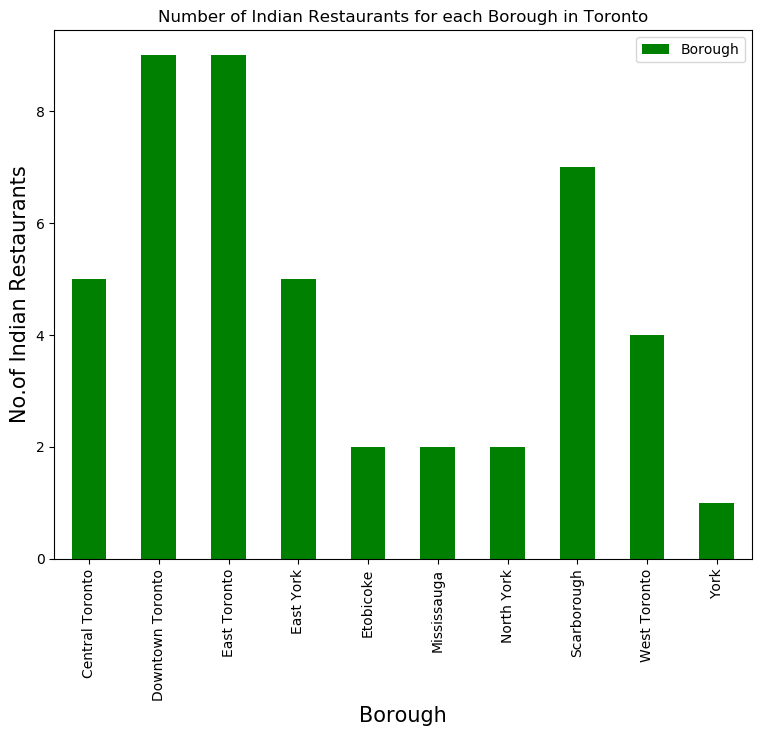

In [12]:
plt.figure(figsize=(9,7), dpi = 100)
# title
plt.title('Number of Indian Restaurants for each Borough in Toronto')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Restaurants', fontsize=15)
#giving a bar plot
indian_rest_tn.groupby('Borough')['ID'].count().plot(kind='bar', color='g', label='Borough')
#legend
plt.legend()
#displays the plot
plt.show()

In [14]:
indian_rest_tn.shape

(46, 4)

*_There are 46 Indian Restaurants in Toronto._
_Downtown and East Toronto has the maximum number of Indian restaurants._*

In [15]:
# Get the list of Indian restaurants in Downtown and East Toronto 
indian_rest_tn[(indian_rest_tn['Borough']=='Downtown Toronto') | (indian_rest_tn['Borough']=='East Toronto')]

,Borough,Neighborhood,ID,Name
8,East Toronto,The Beaches,4dcd7c6352b1f8915b7e7f7e,Delhi Bistro
14,East Toronto,"The Danforth West, Riverdale",4c1d5337eac020a1cb1048c2,Sher-E-Punjab
15,East Toronto,"The Beaches West, India Bazaar",4ae0c7a8f964a520638221e3,Udupi Palace
16,East Toronto,"The Beaches West, India Bazaar",4afc9816f964a520312422e3,Motimahal
17,East Toronto,"The Beaches West, India Bazaar",4bac30a2f964a52018ea3ae3,Bombay Chowpatty
18,East Toronto,"The Beaches West, India Bazaar",4ad9052cf964a520301721e3,Regency Restaurant
19,East Toronto,"The Beaches West, India Bazaar",4bbcc0efa0a0c9b60ebd1a0f,Haandi 2000
20,East Toronto,"The Beaches West, India Bazaar",4d8d278a1d06b1f712942a3b,Gautama
21,East Toronto,"The Beaches West, India Bazaar",4edd30c09adfe5cbe2818dc4,Lahori Taste & Burger House
25,Downtown Toronto,"Cabbagetown, St. James Town",4c8c21fdf0ce236ab28e15ef,Butter Chicken Factory


**Lets find out how many Indian restaurants are there for each Neighborhood in Toronto**

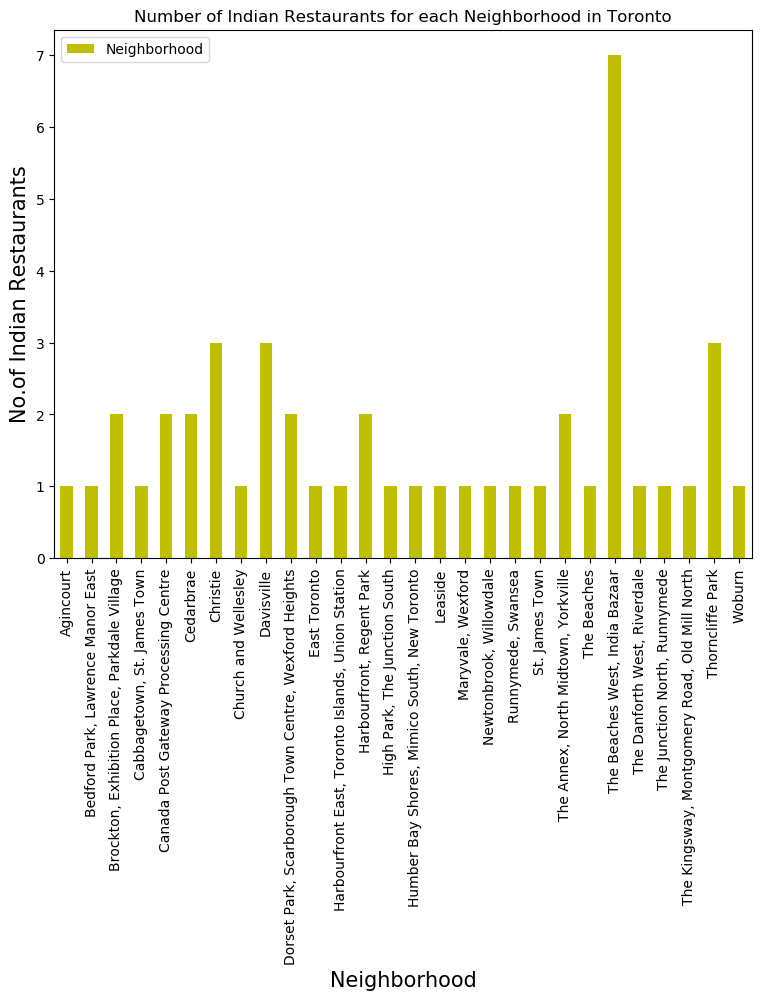

In [16]:
plt.figure(figsize=(9,7), dpi = 100)
# title
plt.title('Number of Indian Restaurants for each Neighborhood in Toronto')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Restaurants', fontsize=15)
#giving a bar plot
indian_rest_tn.groupby('Neighborhood')['ID'].count().plot(kind='bar', color='y', label='Neighborhood')
#legend
plt.legend()
#displays the plot
plt.show()

**Lets find out top 5 Neighborhood that has the most Indian restaurants in Toronto**

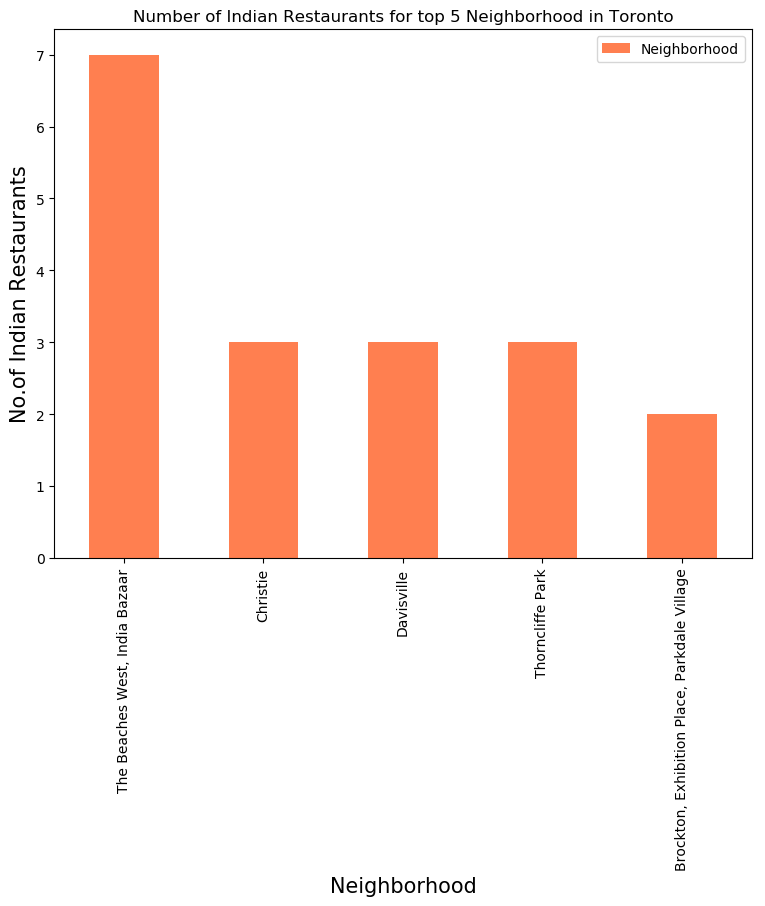

In [17]:
plt.figure(figsize=(9,7), dpi = 100)
# title
plt.title('Number of Indian Restaurants for top 5 Neighborhood in Toronto')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Restaurants', fontsize=15)
#giving a bar plot
indian_rest_tn.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar', color='coral', label='Neighborhood')
#legend
plt.legend()
#displays the plot
plt.show()

We see that there are 8 Indian restaurants in 'The Beaches West, India Bazaar' neighborhood

In [20]:
# Get the list of Indian restaurants in 'The Beaches West, India Bazaar' neighborhood
indian_rest_tn[(indian_rest_tn['Neighborhood']=='The Beaches West, India Bazaar')]

,Borough,Neighborhood,ID,Name
15,East Toronto,"The Beaches West, India Bazaar",4ae0c7a8f964a520638221e3,Udupi Palace
16,East Toronto,"The Beaches West, India Bazaar",4afc9816f964a520312422e3,Motimahal
17,East Toronto,"The Beaches West, India Bazaar",4bac30a2f964a52018ea3ae3,Bombay Chowpatty
18,East Toronto,"The Beaches West, India Bazaar",4ad9052cf964a520301721e3,Regency Restaurant
19,East Toronto,"The Beaches West, India Bazaar",4bbcc0efa0a0c9b60ebd1a0f,Haandi 2000
20,East Toronto,"The Beaches West, India Bazaar",4d8d278a1d06b1f712942a3b,Gautama
21,East Toronto,"The Beaches West, India Bazaar",4edd30c09adfe5cbe2818dc4,Lahori Taste & Burger House


In [23]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood','ID','Name','Likes','Rating','Tips','Price']
indian_rest_details_tn=pd.DataFrame(columns=column_names)
count=1
for row in indian_rest_tn.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_addl_details(ID)
        print(venue_details)
        id,name,likes,rating,tips,price=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
    #id,name,likes,rating,tips,price=[0]*6 
    indian_rest_details_tn = indian_rest_details_tn.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips,
                                                'Price': price
                                               }, ignore_index=True)
    count+=1    

Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips, Price]
Index: []
No data available for id= 4c632edeedd320a19ad5ae29
                         ID             Name  Likes  Rating  Tips     Price
0  4d6008f829ef236a8832a059  CANBE Foods Inc     22     8.2     8  Moderate
                         ID           Name  Likes  Rating  Tips     Price
0  4c77fc87bd346dcb8c90f0ef  La Sani Grill     13     6.9    12  Moderate
                         ID     Name  Likes  Rating  Tips     Price
0  5226562611d2cd49d83ef03b  Kairali      9     7.7     6  Moderate
                         ID                                         Name  \
0  4bf96c435317a593a23a017f  Karaikudi Chettinad South Indian Restaurant   

   Likes  Rating  Tips     Price  
0     27     6.2    23  Moderate  
                         ID               Name  Likes  Rating  Tips  Price
0  4c27cddd9fb5d13a8cab9857  Patna Kebab House      4     7.8     6  Cheap
                         ID                                Name  L

In [24]:
indian_rest_details_tn[indian_rest_details_tn.Borough=='East Toronto']

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips,Price
8,East Toronto,The Beaches,4dcd7c6352b1f8915b7e7f7e,Delhi Bistro,5,6.6,3,Moderate
14,East Toronto,"The Danforth West, Riverdale",4c1d5337eac020a1cb1048c2,Sher-E-Punjab,10,7.5,7,Moderate
15,East Toronto,"The Beaches West, India Bazaar",4ae0c7a8f964a520638221e3,Udupi Palace,79,8.6,31,Cheap
16,East Toronto,"The Beaches West, India Bazaar",4afc9816f964a520312422e3,Motimahal,25,8,13,Moderate
17,East Toronto,"The Beaches West, India Bazaar",4bac30a2f964a52018ea3ae3,Bombay Chowpatty,7,7.3,5,Moderate
18,East Toronto,"The Beaches West, India Bazaar",4ad9052cf964a520301721e3,Regency Restaurant,5,6.6,2,Moderate
19,East Toronto,"The Beaches West, India Bazaar",4bbcc0efa0a0c9b60ebd1a0f,Haandi 2000,3,6.3,7,Moderate
20,East Toronto,"The Beaches West, India Bazaar",4d8d278a1d06b1f712942a3b,Gautama,15,6.1,15,Moderate
21,East Toronto,"The Beaches West, India Bazaar",4d8d278a1d06b1f712942a3b,Gautama,15,6.1,15,Moderate


In [25]:
indian_rest_details_tn.tail()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips,Price
41,West Toronto,"Runnymede, Swansea",525e1812498e2c14b4d80b8b,Bukhara indian cuisine,6,6.8,3,Moderate
42,Mississauga,Canada Post Gateway Processing Centre,595fb4ab178a2a1a946eec2b,Barbq Tonight,7,7.2,1,Moderate
43,Mississauga,Canada Post Gateway Processing Centre,4bff0c5668c7a5932a1f4044,Zauq,9,6,11,Moderate
44,Etobicoke,"Humber Bay Shores, Mimico South, New Toronto",4bc10d44abf49521d773c093,Bombay on the Lake,6,7.3,9,Moderate
45,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",4af1c64ff964a5200ae321e3,Chutneys Fine Indian Cuisine,5,6.7,10,Moderate


In [26]:
indian_rest_details_tn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 8 columns):
Borough         46 non-null object
Neighborhood    46 non-null object
ID              46 non-null object
Name            46 non-null object
Likes           46 non-null object
Rating          46 non-null object
Tips            46 non-null object
Price           46 non-null object
dtypes: object(8)
memory usage: 3.0+ KB


In order for us to do some math around the ratings, likes columns, we need to convert the columns to integer or float.

In [27]:
indian_rest_details_tn['Likes']=indian_rest_details_tn['Likes'].astype('float64')
indian_rest_details_tn['Rating']=indian_rest_details_tn['Rating'].astype('float64')
indian_rest_details_tn['Tips']=indian_rest_details_tn['Tips'].astype('float64')

In [28]:
indian_rest_details_tn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 8 columns):
Borough         46 non-null object
Neighborhood    46 non-null object
ID              46 non-null object
Name            46 non-null object
Likes           46 non-null float64
Rating          46 non-null float64
Tips            46 non-null float64
Price           46 non-null object
dtypes: float64(3), object(5)
memory usage: 3.0+ KB


Lets get the Indian restaurant with maximum rating, likes and tips

In [29]:
# Restaurant with maximum Rating
indian_rest_details_tn.iloc[indian_rest_details_tn['Rating'].idxmax()]

Borough                             Central Toronto
Neighborhood    The Annex, North Midtown, Yorkville
ID                         4c62c59ce1621b8dd0332453
Name                          Roti Cuisine of India
Likes                                            39
Rating                                          8.9
Tips                                             18
Price                                      Moderate
Name: 32, dtype: object

In [30]:
indian_rest_tn_neighborhood=indian_rest_details_tn.groupby(['ID','Borough','Neighborhood','Name'], as_index=False).mean()[['ID','Borough','Neighborhood','Name','Rating']]
indian_rest_tn_neighborhood.columns=['ID','Borough','Neighborhood','Indian Restaurant Name','Rating']
indian_rest_tn_rating=indian_rest_tn_neighborhood.sort_values(['Rating'],ascending=False)
indian_rest_tn_rating_top5=indian_rest_tn_rating.head()
indian_rest_tn_rating_top5

,ID,Borough,Neighborhood,Indian Restaurant Name,Rating
26,4c62c59ce1621b8dd0332453,Central Toronto,"The Annex, North Midtown, Yorkville",Roti Cuisine of India,8.9
3,4adb969ef964a520332921e3,Downtown Toronto,Christie,Banjara Indian Cuisine,8.9
4,4ae0c7a8f964a520638221e3,East Toronto,"The Beaches West, India Bazaar",Udupi Palace,8.6
28,4c8c21fdf0ce236ab28e15ef,Downtown Toronto,"Cabbagetown, St. James Town",Butter Chicken Factory,8.5
5,4aecbbb0f964a520bcca21e3,West Toronto,"Brockton, Exhibition Place, Parkdale Village",Mother India,8.4


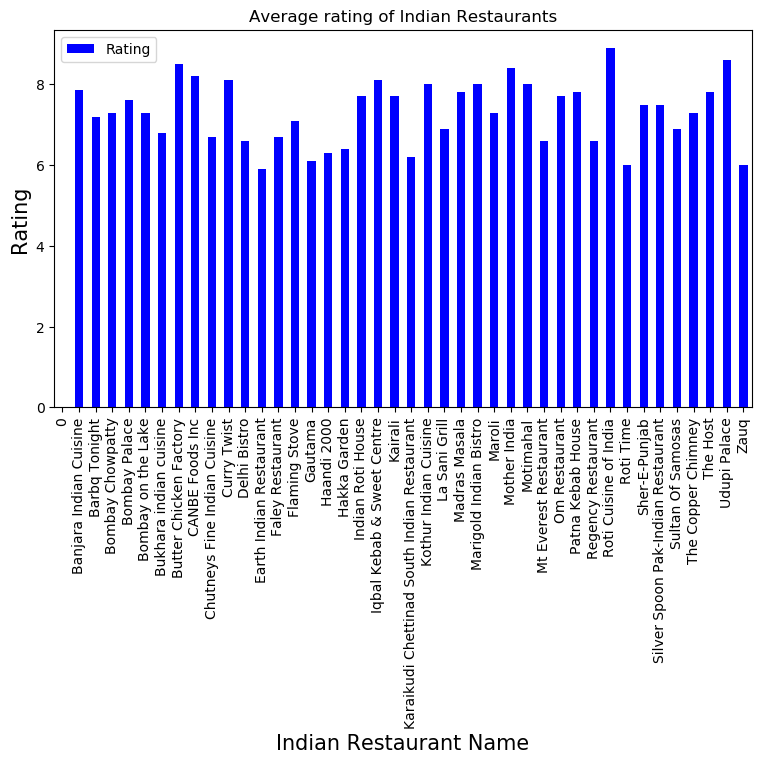

In [31]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Indian Restaurants')
#On x-axis
plt.xlabel('Indian Restaurant Name', fontsize = 15)
#On y-axis
plt.ylabel('Rating', fontsize=15)
#giving a bar plot
indian_rest_tn_neighborhood.groupby('Indian Restaurant Name').mean()['Rating'].plot(kind='bar', label='Rating', color='b')
#legend
plt.legend()
#displays the plot
plt.show()

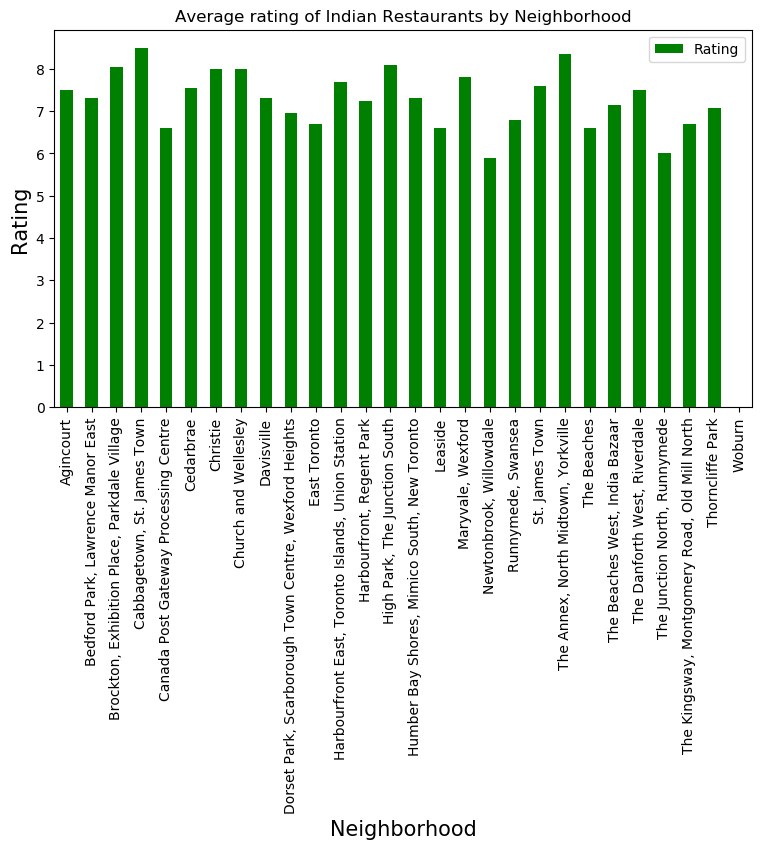

In [32]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Indian Restaurants by Neighborhood')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('Rating', fontsize=15)
#giving a bar plot
indian_rest_tn_neighborhood.groupby('Neighborhood').mean()['Rating'].plot(kind='bar',label='Rating', color='g')
#legend
plt.legend()
#displays the plot
plt.show()

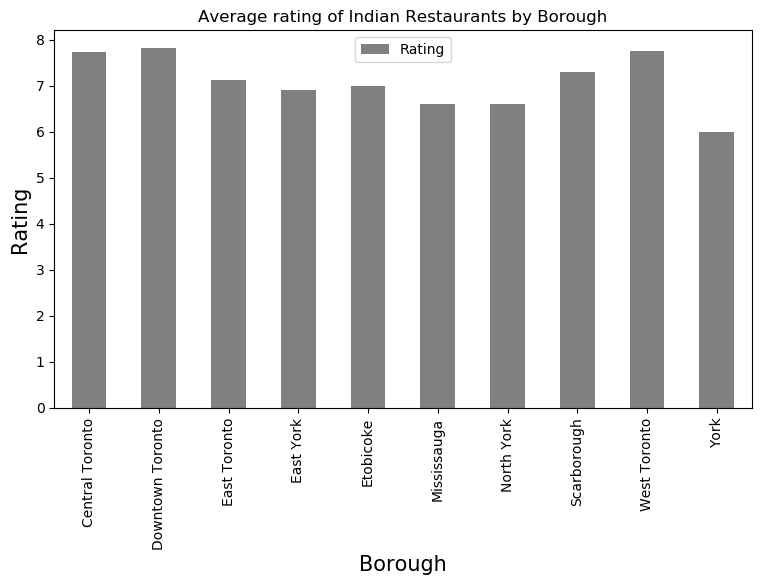

In [90]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Indian Restaurants by Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Rating', fontsize=15)
#giving a bar plot
indian_rest_tn_neighborhood.groupby('Borough').mean()['Rating'].plot(kind='bar',label='Rating', color='grey')
#legend
plt.legend()
#displays the plot
plt.show()

In [33]:
# Restaurant with maximum number of likes
indian_rest_details_tn.iloc[indian_rest_details_tn['Likes'].idxmax()]

Borough                 Downtown Toronto
Neighborhood                    Christie
ID              4adb969ef964a520332921e3
Name              Banjara Indian Cuisine
Likes                                137
Rating                               8.9
Tips                                  72
Price                              Cheap
Name: 34, dtype: object

In [34]:
indian_rest_tn_neighborhood=indian_rest_details_tn.groupby(['ID','Neighborhood','Name'], as_index=False).max()[['ID','Neighborhood','Name','Likes']]
indian_rest_tn_neighborhood.columns=['ID','Neighborhood','Name','Likes']
indian_rest_tn_likes=indian_rest_tn_neighborhood.sort_values(['Likes'],ascending=False)
indian_rest_tn_likes.head()

,ID,Neighborhood,Name,Likes
3,4adb969ef964a520332921e3,Christie,Banjara Indian Cuisine,137.0
4,4ae0c7a8f964a520638221e3,"The Beaches West, India Bazaar",Udupi Palace,79.0
5,4aecbbb0f964a520bcca21e3,"Brockton, Exhibition Place, Parkdale Village",Mother India,46.0
39,50b79b94e4b0a577af25a83f,"Harbourfront East, Toronto Islands, Union Station",Indian Roti House,39.0
26,4c62c59ce1621b8dd0332453,"The Annex, North Midtown, Yorkville",Roti Cuisine of India,39.0


In [35]:
# Restaurant with maximum number of Tips
indian_rest_details_tn.iloc[indian_rest_details_tn['Tips'].idxmax()]

Borough                 Downtown Toronto
Neighborhood                    Christie
ID              4adb969ef964a520332921e3
Name              Banjara Indian Cuisine
Likes                                137
Rating                               8.9
Tips                                  72
Price                              Cheap
Name: 34, dtype: object

In [36]:
indian_rest_tn_neighborhood=indian_rest_details_tn.groupby(['ID','Neighborhood','Name'], as_index=False).max()[['ID','Neighborhood','Name','Tips']]
indian_rest_tn_neighborhood.columns=['ID','Neighborhood','Name','Tips']
indian_rest_tn_tips=indian_rest_tn_neighborhood.sort_values(['Tips'],ascending=False)
indian_rest_tn_tips.head()

,ID,Neighborhood,Name,Tips
3,4adb969ef964a520332921e3,Christie,Banjara Indian Cuisine,72.0
4,4ae0c7a8f964a520638221e3,"The Beaches West, India Bazaar",Udupi Palace,31.0
5,4aecbbb0f964a520bcca21e3,"Brockton, Exhibition Place, Parkdale Village",Mother India,31.0
22,4bf96c435317a593a23a017f,"Dorset Park, Scarborough Town Centre, Wexford ...",Karaikudi Chettinad South Indian Restaurant,23.0
14,4b7369d7f964a52049ad2de3,Christie,Madras Masala,21.0


#### Toronto Area Restaurants - By Rating

In [37]:
indian_rest_details_tn.sort_values(by='Rating', ascending=False).head(10)

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips,Price
32,Central Toronto,"The Annex, North Midtown, Yorkville",4c62c59ce1621b8dd0332453,Roti Cuisine of India,39.0,8.9,18.0,Moderate
34,Downtown Toronto,Christie,4adb969ef964a520332921e3,Banjara Indian Cuisine,137.0,8.9,72.0,Cheap
15,East Toronto,"The Beaches West, India Bazaar",4ae0c7a8f964a520638221e3,Udupi Palace,79.0,8.6,31.0,Cheap
25,Downtown Toronto,"Cabbagetown, St. James Town",4c8c21fdf0ce236ab28e15ef,Butter Chicken Factory,19.0,8.5,10.0,Moderate
37,West Toronto,"Brockton, Exhibition Place, Parkdale Village",4aecbbb0f964a520bcca21e3,Mother India,46.0,8.4,31.0,Moderate
1,Scarborough,Cedarbrae,4d6008f829ef236a8832a059,CANBE Foods Inc,22.0,8.2,8.0,Moderate
40,West Toronto,"High Park, The Junction South",4b511f6ff964a520994327e3,Curry Twist,20.0,8.1,17.0,Moderate
10,East York,Thorncliffe Park,4daf08e66e81e2dffdd4fe40,Iqbal Kebab & Sweet Centre,13.0,8.1,7.0,Cheap
16,East Toronto,"The Beaches West, India Bazaar",4afc9816f964a520312422e3,Motimahal,25.0,8.0,13.0,Moderate
26,Downtown Toronto,Church and Wellesley,4bedf8b5e24d20a17b567214,Kothur Indian Cuisine,13.0,8.0,16.0,Moderate


#### Toronto Area Restaurants - By Likes

In [38]:
indian_rest_details_tn.sort_values(by='Likes', ascending=False).head(10)

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips,Price
34,Downtown Toronto,Christie,4adb969ef964a520332921e3,Banjara Indian Cuisine,137.0,8.9,72.0,Cheap
15,East Toronto,"The Beaches West, India Bazaar",4ae0c7a8f964a520638221e3,Udupi Palace,79.0,8.6,31.0,Cheap
37,West Toronto,"Brockton, Exhibition Place, Parkdale Village",4aecbbb0f964a520bcca21e3,Mother India,46.0,8.4,31.0,Moderate
32,Central Toronto,"The Annex, North Midtown, Yorkville",4c62c59ce1621b8dd0332453,Roti Cuisine of India,39.0,8.9,18.0,Moderate
30,Downtown Toronto,"Harbourfront East, Toronto Islands, Union Station",50b79b94e4b0a577af25a83f,Indian Roti House,39.0,7.7,14.0,Moderate
35,Downtown Toronto,Christie,4b7369d7f964a52049ad2de3,Madras Masala,32.0,7.8,21.0,Moderate
33,Central Toronto,"The Annex, North Midtown, Yorkville",4ad4c060f964a5204af720e3,The Host,29.0,7.8,12.0,Moderate
4,Scarborough,"Dorset Park, Scarborough Town Centre, Wexford ...",4bf96c435317a593a23a017f,Karaikudi Chettinad South Indian Restaurant,27.0,6.2,23.0,Moderate
16,East Toronto,"The Beaches West, India Bazaar",4afc9816f964a520312422e3,Motimahal,25.0,8.0,13.0,Moderate
23,Central Toronto,Davisville,4b7ccc72f964a520e3a52fe3,Banjara Indian Cuisine,23.0,6.8,19.0,Moderate


In [53]:
indian_rest_tn_merged = pd.merge(indian_rest_details_tn,toronto_data, on='Neighborhood')

indian_rest_tn_merged

,Borough_x,Neighborhood,ID,Name,Likes,Rating,Tips,Price,Borough_y,Latitude,Longitude
0,Scarborough,Woburn,0,0,0.0,0.0,0.0,0,Scarborough,43.770992,-79.216917
1,Scarborough,Cedarbrae,4d6008f829ef236a8832a059,CANBE Foods Inc,22.0,8.2,8.0,Moderate,Scarborough,43.773136,-79.239476
2,Scarborough,Cedarbrae,4c77fc87bd346dcb8c90f0ef,La Sani Grill,13.0,6.9,12.0,Moderate,Scarborough,43.773136,-79.239476
3,Scarborough,"Dorset Park, Scarborough Town Centre, Wexford ...",5226562611d2cd49d83ef03b,Kairali,9.0,7.7,6.0,Moderate,Scarborough,43.757410,-79.273304
4,Scarborough,"Dorset Park, Scarborough Town Centre, Wexford ...",4bf96c435317a593a23a017f,Karaikudi Chettinad South Indian Restaurant,27.0,6.2,23.0,Moderate,Scarborough,43.757410,-79.273304
5,Scarborough,"Maryvale, Wexford",4c27cddd9fb5d13a8cab9857,Patna Kebab House,4.0,7.8,6.0,Cheap,Scarborough,43.750072,-79.295849
6,Scarborough,Agincourt,4d570727fb65236a7f600db4,Silver Spoon Pak-Indian Restaurant,10.0,7.5,6.0,Moderate,Scarborough,43.794200,-79.262029
7,North York,"Newtonbrook, Willowdale",4b43dde2f964a52099ec25e3,Earth Indian Restaurant,4.0,5.9,11.0,Moderate,North York,43.789053,-79.408493
8,East Toronto,The Beaches,4dcd7c6352b1f8915b7e7f7e,Delhi Bistro,5.0,6.6,3.0,Moderate,East Toronto,43.676357,-79.293031
9,East York,Leaside,504bcf32e4b0ef19b0e2ecf8,Mt Everest Restaurant,8.0,6.6,6.0,Moderate,East York,43.709060,-79.363452


In [67]:
!conda install -c conda-forge folium=0.5.0 --yes
import folium


Solving environment: done

# All requested packages already installed.



In [70]:
# create map and display it
# get geo location of address
def geo_location(address):
    geolocator = Nominatim(user_agent="my_explorer")
    location = geolocator.geocode(address)
    Latitude = location.latitude
    Longitude = location.longitude
return Latitude,Longitude

(43.706748299999994, -79.5940544)

In [74]:
toronto_map = folium.Map(location=geo_location('Toronto'), zoom_start=12)

In [71]:
# instantiate a feature group for the restaurants in the dataframe
restaurants = folium.map.FeatureGroup()
# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in indian_rest_tn_merged[['Latitude','Longitude']].values:
    restaurants.add_child(
    folium.CircleMarker(
    [lat, lng],
    radius=10, # define how big you want the circle markers to be
    color='orange',
    fill=True,
    fill_color='black',
    fill_opacity=0.6
    )
)

In [73]:
indian_rest_tn_merged['Label']=indian_rest_tn_merged['Neighborhood']+', '+indian_rest_tn_merged['Borough_x']+'('+indian_rest_tn_merged['Rating'].map(str)+')'

In [77]:
# add pop-up text to each marker on the map
for lat, lng, label in indian_rest_tn_merged[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(toronto_map)        
# add incidents to map
toronto_map.add_child(restaurants)

In [79]:
toronto_map.save('toronto_indian_restaurants.html') #Sometimes the map is not visible. Hence an image is extracted and uploaded to GitHub. Filename=toronto_indian_restaurants.jpg

# 5. Results, Conclusion and Discussion

Based on the data set and analysis
* The Beaches West, India Bazaar neighborhood in East Toronto Borough is the best place for Indian restaurants
* Christie, Davisville and Thorncliffe park are the next best neighborhoods for Indian cuisine
* Boroughs- Downtown Toronto, East Toronto and Scarborough has the most number of Indian restaurants in Greater Toronto Area
* Banjara Indian Cuisine is rated as the best indian restaurant with cheap pricing 
* Roti Indian cuisine is equally good but it is a little expensive

From an Immigrant perspective, it is better to stay in the East Toronto area to start, as it has the most Indian restaurants.

To answer the other questions from our background-

* Which is the best place to stay if I prefer Indian Cuisine? 
__The Beaches West, Indian Bazaar neighborhood__
* What is the best location in Toronto for Indian Cuisine? 
__Downtown and East Toronto__
* Which areas lack Indian Restaurants and have potential for a new Indian Restaurant? 
__Etobioke, North York and York seem to have potential for some Indian cuisine. But the demographic and 'likes' need to be researched for market analysis.__
